In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# MNIST 데이터셋 다운로드 (1분 가량 소요)
mnist = datasets.fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist.data, mnist.target
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [4]:
# 이진 분류용 훈련 데이터 준비
def prepare_binary_classification_data(X, y, label1, label2):
    binary_index = (y == label1) | (y == label2)
    X_binary = X[binary_index]
    y_binary = y[binary_index]
    y_map = {label1: -1, label2: 1}
    y_binary = np.array([y_map[label] for label in y_binary])
    return X_binary, y_binary

X_train_binary, y_train_binary = prepare_binary_classification_data(X_train, y_train, 3, 5)
X_test_binary, y_test_binary = prepare_binary_classification_data(X_test, y_test, 3, 5)

X_train_binary.shape, X_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((10763, 784), (2691, 784), (10763,), (2691,))

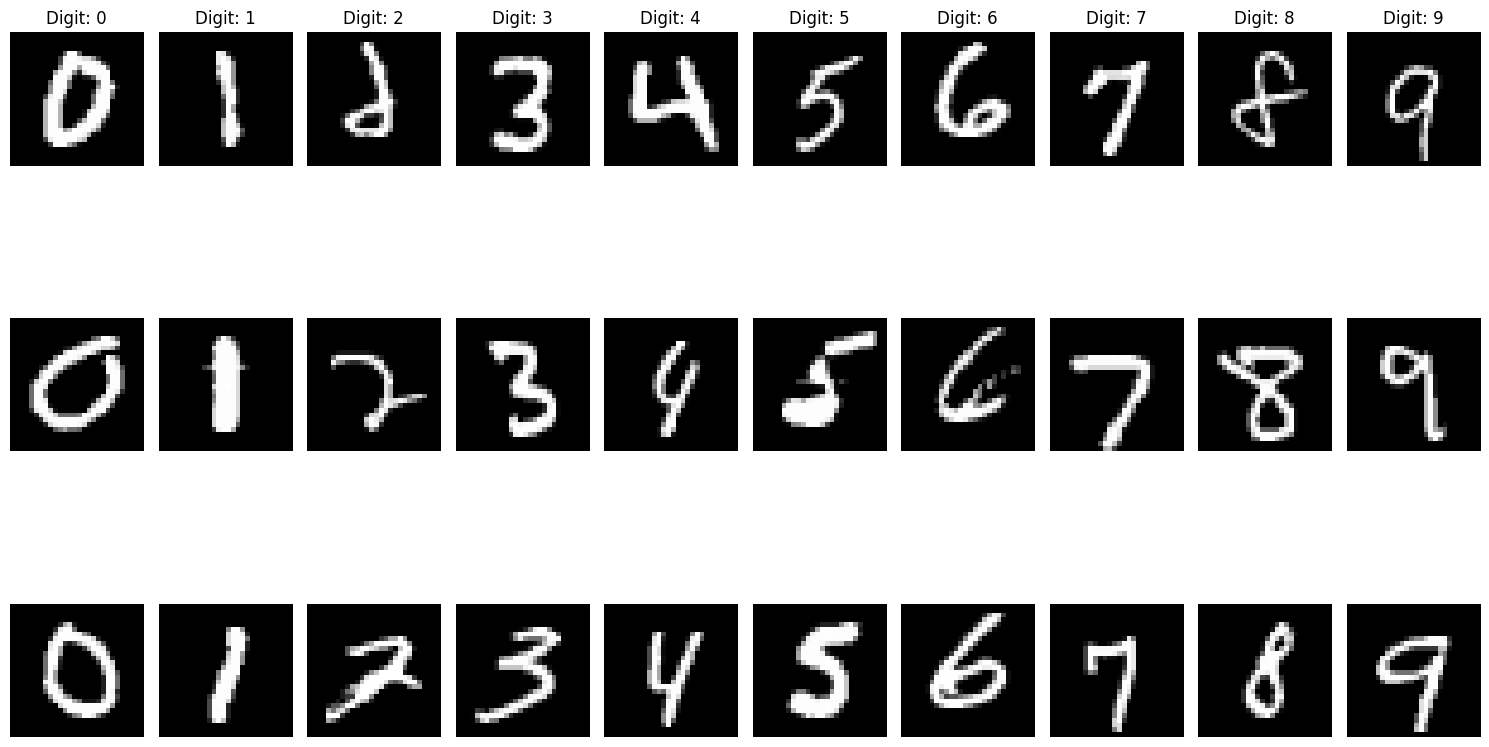

In [5]:
# 데이터 시각화
n_classes = 10
n_samples_per_class = 3
samples_per_class = {i: [] for i in range(n_classes)}

for digit in range(n_classes):
    digit_indices = np.where(y == digit)[0]
    selected_indices = np.random.choice(digit_indices, n_samples_per_class, replace=False)
    samples_per_class[digit] = selected_indices

plt.figure(figsize=(15, 10))
for digit in range(n_classes):
    for i in range(n_samples_per_class):
        idx = samples_per_class[digit][i]

        plt.subplot(n_samples_per_class, n_classes, i * n_classes + digit + 1)
        plt.imshow(X.iloc[idx].values.reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title(f"Digit: {digit}")
        plt.axis('off')

plt.tight_layout()
plt.show()

## 1. SVM from scratch

fit 함수의 가중치 업데이트 부분을 채워주세요! 가중치 업데이트 이외의 코드는 수정하면 안됩니다.

조건: 분류 정확도 0.9 이상

참고자료: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [7]:
class SVMClassifier:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        # 이 부분은 수정하시면 안됩니다.
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.label_map = None
        self.inverse_label_map = None

    def fit(self, X, y):
        # 이 부분은 수정하시면 안됩니다.
        unique_labels = np.unique(y)
        if len(unique_labels) != 2:
            raise ValueError("This SVM implementation supports only binary classification.")

        self.label_map = {unique_labels[0]: -1, unique_labels[1]: 1}
        self.inverse_label_map = {-1: unique_labels[0], 1: unique_labels[1]}

        y_ = np.array([self.label_map[label] for label in y])

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0


        # 이 부분을 채워주세요.
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition =  y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b += self.learning_rate * y_[idx]


    def predict(self, X):
      linear_output = np.dot(X, self.w) + self.b
      return np.where(linear_output >= 0, 1, -1)

In [8]:
svm = SVMClassifier()

fit_start = time.time()
svm.fit(X_train_binary, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_binary)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

Accuracy: 0.9602378298030472
Fitting time: 126.44127798080444 seconds
Prediction Time: 0.0020325183868408203 seconds


## 2. Dimensionality Reduction

PCA와 LDA를 활용하여 데이터 차원을 축소한 뒤, 모델 학습을 진행해주세요!

PCA 적용하기

In [9]:
from sklearn.decomposition import PCA

# PCA를 사용하여 X_train_binary의 차원을 축소해주세요.

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_binary)
X_test_pca = pca.transform(X_test_binary)

print(X_train_pca.shape, X_test_pca.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_pca, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_pca)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 2) (2691, 2)
Accuracy: 0.7591973244147158
Fitting time: 116.57318234443665 seconds
Prediction Time: 0.0005462169647216797 seconds


LDA 적용하기

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_binary, y_train_binary)
X_test_lda = lda.transform(X_test_binary)
print(X_train_lda.shape, X_test_lda.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_lda, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_lda)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 1) (2691, 1)
Accuracy: 0.94611668524712
Fitting time: 108.84740686416626 seconds
Prediction Time: 0.00035762786865234375 seconds


## 3. Multiclass SVM

OvO (One vs One) 방법론을 사용하여 Multiclass svm classifier를 구현해주세요!

In [11]:
# 학습 효율성을 위해 데이터셋의 일부만 사용
mnist_df = pd.concat([mnist.data, mnist.target], axis=1)
mnist_df = mnist_df.groupby('class').apply(lambda x: x.sample(frac=0.01, random_state=42)).reset_index(drop=True)

X, y = mnist_df.drop('class', axis=1), mnist_df['class']
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((560, 784), (140, 784), (560,), (140,))

In [12]:
y_train.unique()

[9, 6, 1, 3, 7, 5, 8, 2, 4, 0]
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [13]:
from itertools import combinations
from collections import Counter
import numpy as np

class OvOSVMClassifier:
    def __init__(self, base_classifier, n_classes):
        self.base_classifier = base_classifier
        self.n_classes = n_classes
        self.classifiers = {}
        self.pairs = list(combinations(range(n_classes), 2))  # 모든 클래스 쌍을 만듬

    def fit(self, X, y):
        # 모든 클래스 쌍에 대해 이진 SVM 분류기를 학습
        for (class1, class2) in self.pairs:
            print(f"Training classifier for classes {class1} vs {class2}")
            clf = self.base_classifier()  # 새로운 SVM 분류기 생성
            X_binary, y_binary = self.prepare_binary_classification_data(X, y, class1, class2)
            clf.fit(X_binary, y_binary)
            self.classifiers[(class1, class2)] = clf  # 분류기를 저장

    def prepare_binary_classification_data(self, X, y, class1, class2):
        # 주어진 두 클래스(class1, class2)에 해당하는 데이터만 사용하여 이진 분류용 데이터를 만듬
        binary_index = (y == class1) | (y == class2)
        X_binary = X[binary_index]
        y_binary = y[binary_index]
        y_map = {class1: -1, class2: 1}
        y_binary = np.array([y_map[label] for label in y_binary])
        return X_binary, y_binary

    def predict(self, X):
        # 각 데이터 포인트에 대해 모든 이진 분류기의 예측 결과를 집계
        votes = np.zeros((X.shape[0], self.n_classes))
        for (class1, class2), clf in self.classifiers.items():
            predictions = clf.predict(X)
            for i, pred in enumerate(predictions):
                if pred == -1:
                    votes[i, class1] += 1
                else:
                    votes[i, class2] += 1

        return np.argmax(votes, axis=1)


X_train.shape, X_test.shape, y_train.shape, y_test.shape


ovo_svm = OvOSVMClassifier(base_classifier=SVMClassifier, n_classes=10)

fit_start = time.time()
ovo_svm.fit(X_train, y_train)
fit_end = time.time()

pred_start = time.time()
y_pred = ovo_svm.predict(X_test)
pred_end = time.time()

# 정확도 평가
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction time: {pred_end - pred_start} seconds")

Training classifier for classes 0 vs 1
Training classifier for classes 0 vs 2
Training classifier for classes 0 vs 3
Training classifier for classes 0 vs 4
Training classifier for classes 0 vs 5
Training classifier for classes 0 vs 6
Training classifier for classes 0 vs 7
Training classifier for classes 0 vs 8
Training classifier for classes 0 vs 9
Training classifier for classes 1 vs 2
Training classifier for classes 1 vs 3
Training classifier for classes 1 vs 4
Training classifier for classes 1 vs 5
Training classifier for classes 1 vs 6
Training classifier for classes 1 vs 7
Training classifier for classes 1 vs 8
Training classifier for classes 1 vs 9
Training classifier for classes 2 vs 3
Training classifier for classes 2 vs 4
Training classifier for classes 2 vs 5
Training classifier for classes 2 vs 6
Training classifier for classes 2 vs 7
Training classifier for classes 2 vs 8
Training classifier for classes 2 vs 9
Training classifier for classes 3 vs 4
Training classifier for c